In [1]:
import numpy as np
import os
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization

from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.models import Model, Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Dropout, Convolution2D, Activation, MaxPooling2D, GlobalAveragePooling2D
from random import shuffle

from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import math

from keras.optimizers import SGD, Adam
from keras import losses
from keras.preprocessing.image import ImageDataGenerator, array_to_img

#master_path = 'C:\\Users\\pochetti\\WorkDocs\\Desktop\\Fra\\Francesco\\Kaggle\\IEEE'
master_path = "/home/paperspace/IEEE"

Using TensorFlow backend.
/home/paperspace/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


** Is there a GPU on the machine? **

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4289362492012536167
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7773745972
locality {
  bus_id: 1
}
incarnation: 13617983144464762836
physical_device_desc: "device: 0, name: Quadro M4000, pci bus id: 0000:00:05.0, compute capability: 5.2"
]


### Helper Functions

In [3]:
def read_crop_save(frompath, topath):
    img = Image.open(frompath)
    w, h = img.size
    img = img.crop((w // 2 - 256, h // 2 - 256, w // 2 + 256, h // 2 + 256)) 
    new_array = np.array(img)
    plt.imsave(topath, new_array)
    return

#################################################################
#################################################################

# used to copy files according to each fold
def copy_images(df, directory):
    destination_directory = os.path.join(os.path.sep, master_path, 'crossval', directory)
    print("copying {} files to {}...".format(directory, destination_directory))

    # remove all files from previous fold
    if os.path.exists(destination_directory):
        shutil.rmtree(destination_directory)

    # create folder for files from this fold
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    # create subfolders for each class
    for c in set(list(df['class'])):
        if not os.path.exists(os.path.join(os.path.sep, destination_directory, c)):
            os.makedirs(os.path.join(os.path.sep, destination_directory, c))

    # copy files for this fold from a directory holding all the files
    for i, row in df.iterrows():
        try:
            # this is the path to all of your images kept together in a separate folder
            path_from = row['filename']
            path_to = os.path.join(os.path.sep, destination_directory, row['class'])

            # move from folder keeping all files to training, test, or validation folder (the "directory" argument)
            shutil.copy(path_from, path_to)
        except Exception as e:
            print("Error when copying {}: {}".format(row['filename'], str(e)))

#################################################################
#################################################################            
            
def preprocess_input_vgg16(x):
    from keras.applications.vgg16 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

#################################################################
#################################################################

def preprocess_input_inception_v3(x):
    from keras.applications.inception_v3 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

#################################################################
#################################################################

def preprocess_input_xception(x):
    from keras.applications.xception import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

#################################################################
#################################################################

def preprocess_input_resnet50(x):
    from keras.applications.resnet50 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

#################################################################
#################################################################

class CheckLr(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(K.eval(lr_with_decay))

#################################################################
#################################################################        
        
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

#################################################################
#################################################################

def build_on_bottleneck(which_net):
    
    if which_net == 'vgg16':
        base_model = VGG16(weights='imagenet')
    elif which_net == 'resnet50':
        base_model = ResNet50(weights='imagenet')
    elif which_net == 'xception':
        base_model = Xception(weights='imagenet', include_top=False)
    elif which_net == 'inception_v3':
        base_model = InceptionV3(weights='imagenet', include_top=False)
    
    if which_net not in ['inception_v3', 'xception']:
        j = [i for i, layer in enumerate(base_model.layers) if 'flatten' in layer.name][-1]
    
        x = base_model.layers[j].output
        x = BatchNormalization()(x)
        x = Dense(400, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(200, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation='relu')(x)
        x = Dense(10, activation='softmax')(x)
        
        model = Model(input=base_model.input, output=x)
        for i, layer in enumerate(model.layers):
            if i <= j: layer.trainable = False
    else:
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dense(400, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(200, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation='relu')(x)
        x = Dense(10, activation='softmax')(x)
        
        model = Model(input=base_model.input, output=x)
        for layer in base_model.layers:
            layer.trainable = False
    
    model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])
    
    filepath = os.path.join(os.path.sep, master_path, which_net + "BottleneckWeights.best.hdf5")
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    return model, callbacks_list

#################################################################
#################################################################

def fine_tune(which_net, freeze_up_to):
    
    if which_net == 'vgg16':
        base_model = VGG16(weights='imagenet')
    elif which_net == 'resnet50':
        base_model = ResNet50(weights='imagenet')
    elif which_net == 'xception':
        base_model = Xception(weights='imagenet', include_top=False)
    elif which_net == 'inception_v3':
        base_model = InceptionV3(weights='imagenet', include_top=False)
    
    if which_net not in ['inception_v3', 'xception']:
        j = [i for i, layer in enumerate(base_model.layers) if 'flatten' in layer.name][-1]
    
        x = base_model.layers[j].output
        x = BatchNormalization()(x)
        x = Dense(400, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(200, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation='relu')(x)
        x = Dense(10, activation='softmax')(x)
        
        model = Model(input=base_model.input, output=x)
        
    else:
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dense(400, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(200, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation='relu')(x)
        x = Dense(10, activation='softmax')(x)
        
        model = Model(input=base_model.input, output=x)
    
    model.load_weights(os.path.join(os.path.sep, master_path, which_net + "BottleneckWeights.best.hdf5"))
    
    for layer in model.layers[:freeze_up_to]:
       layer.trainable = False
    for layer in model.layers[freeze_up_to:]:
       layer.trainable = True
    
    filepath = os.path.join(os.path.sep, master_path, which_net + "FineTuneWeights.best.hdf5")
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    return model, callbacks_list    

#################################################################
#################################################################

def save_bottleneck_features(batch_size, which_net):
    
    if which_net == 'vgg16': 
        model = VGG16(weights='imagenet', include_top=False)
        target_size = [224, 224]
        preprocessing_function=preprocess_input_vgg16
    elif which_net == 'resnet50': 
        model = ResNet50(weights='imagenet', include_top=False)
        target_size = [224, 224]
        preprocessing_function=preprocess_input_resnet50
    elif which_net == 'inception_v3':
        model = InceptionV3(weights='imagenet', include_top=False)
        target_size = [299, 299]
        preprocessing_function=preprocess_input_inception_v3
    
    
    datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    generator = datagen.flow_from_directory(os.path.join(os.path.sep, master_path, 'crossval', 'training'),
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    np.save(os.path.join(os.sep, master_path, which_net+'bottleneck_features_train.npy'), 
            bottleneck_features_train)

    generator = datagen.flow_from_directory(os.path.join(os.path.sep, master_path, 'crossval', 'validation'),
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    np.save(os.path.join(os.sep, master_path, which_net+'bottleneck_features_val.npy'), 
            bottleneck_features_validation)
    
    return bottleneck_features_train, bottleneck_features_validation

#################################################################
#################################################################    
    
def define_generators(batch_size, which_net):
    
    if which_net == 'vgg16': 
        target_size = [224, 224]
        preprocessing_function=preprocess_input_vgg16
    elif which_net == 'resnet50': 
        target_size = [224, 224]
        preprocessing_function=preprocess_input_resnet50
    elif which_net == 'inception_v3': 
        target_size = [299, 299]
        preprocessing_function=preprocess_input_inception_v3
    elif which_net == 'xception': 
        target_size = [299, 299]
        preprocessing_function=preprocess_input_xception
    
    train_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function,
                                       rotation_range=15,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=os.path.join(os.path.sep, master_path, 'crossval', 'training'),
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

    validation_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    
    validation_generator = validation_datagen.flow_from_directory(directory=os.path.join(os.path.sep, master_path, 'crossval', 'validation'),
                                                                  target_size=target_size,
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical')
    return train_generator, validation_generator

#################################################################
#################################################################   

def get_unshuffled_labels(X, class_indices):
    s = X.str.split(os.sep).str[-2]
    t1 = s.groupby(s).size().to_dict()
    for i, k in enumerate(class_indices.keys()):
        t1[i] = t1.pop(k)

    t2 = [y for x in [[k] * v for k, v in t1.items()] for y in x]
    return t2

#################################################################
#################################################################   

def reshape_and_concat_features(features):
    reshaped_ = []
    for f in features:
        a, b, c, d = f.shape
        new_f = f.reshape((a, b*c*d))
        reshaped_.append(new_f)
        
    return np.hstack(reshaped_)

#################################################################
#################################################################   

def rfccv(n_estimators, min_samples_split, max_features):
    clf = RandomForestClassifier(n_estimators=int(n_estimators),
                                min_samples_split=int(min_samples_split),
                                max_features=min(max_features, 0.999),
                                random_state=2).fit(bft_shrink, y_t_unshuf)
    return clf.score(bfv_shrink, y_v_unshuf)

** Loading train data paths/labels into a dataframe **

In [4]:
list_paths = []
for subdir, dirs, files in os.walk(master_path + os.sep + "resized"): #"data
    for file in files:
        filepath = subdir + os.sep + file
        list_paths.append(filepath)
        
list_train = [filepath for filepath in list_paths if "resized" in filepath and 'ipynb' not in filepath]
#shuffle(list_train)

labels = [os.path.dirname(filepath).split(os.sep)[-1] for filepath in list_train]
data = pd.DataFrame({'filename': list_train, 'class': labels})

print(data.shape)
data.head()

(2750, 2)


,class,filename
0,Samsung-Galaxy-Note3,/home/paperspace/IEEE/resized/Samsung-Galaxy-N...
1,Samsung-Galaxy-Note3,/home/paperspace/IEEE/resized/Samsung-Galaxy-N...
2,Samsung-Galaxy-Note3,/home/paperspace/IEEE/resized/Samsung-Galaxy-N...
3,Samsung-Galaxy-Note3,/home/paperspace/IEEE/resized/Samsung-Galaxy-N...
4,Samsung-Galaxy-Note3,/home/paperspace/IEEE/resized/Samsung-Galaxy-N...


In [5]:
data.loc[data['class'] == '.ipynb_checkpoints', 'filename']

Series([], Name: filename, dtype: object)

** Splitting dataset into Train and Validation (we fix them now and don't change anymore; other option consists in applying a CV procedure which would involve defining a new train/val split for each iteration) **

In [6]:
X_train, X_val, y_train, y_val = train_test_split(data['filename'], data['class'], test_size=0.25, random_state=42)

print(X_train.shape, X_val.shape)

train = pd.concat([X_train, y_train], axis=1)
validation = pd.concat([X_val, y_val], axis = 1)

copy_images(train, 'training')
copy_images(validation, 'validation')

(2062,) (688,)
copying training files to /home/paperspace/IEEE/crossval/training...
copying validation files to /home/paperspace/IEEE/crossval/validation...


** Checking data generators **

In [8]:
df_y = data['class']
df_x = data['filename']

skf = StratifiedKFold(n_splits = 3)

for i, (train_index, test_index) in enumerate(skf.split(df_x, df_y)):
    x_train, x_val = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train, y_val = df_y.iloc[train_index], df_y.iloc[test_index]

    train = pd.concat([x_train, y_train], axis=1)
    validation = pd.concat([x_val, y_val], axis = 1)
    print('Train Shape:', train.shape)
    print('Validation Shape:', validation.shape)
    
    # copy the images according to the fold
    copy_images(train, 'training')
    copy_images(validation, 'validation')
    
    break

Train Shape: (1830, 2)
Validation Shape: (920, 2)
copying training files to /home/paperspace/IEEE/crossval/training...
copying validation files to /home/paperspace/IEEE/crossval/validation...


Found 2062 images belonging to 10 classes.
Found 688 images belonging to 10 classes.


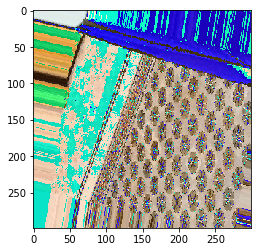

In [7]:
t, v = define_generators(64, 'xception')
plt.imshow(next(t)[0][3])
plt.show()

In [8]:
t.class_indices

{'HTC-1-M7': 0,
 'LG-Nexus-5x': 1,
 'Motorola-Droid-Maxx': 2,
 'Motorola-Nexus-6': 3,
 'Motorola-X': 4,
 'Samsung-Galaxy-Note3': 5,
 'Samsung-Galaxy-S4': 6,
 'Sony-NEX-7': 7,
 'iPhone-4s': 8,
 'iPhone-6': 9}

** (Need to run this cell only once at the beginning of the project to set the dataset up) Resizing train images and saving them back **

In [18]:
list_classes = list(set([os.path.dirname(filepath).split(os.sep)[-1] for filepath in list_paths if "train" in filepath]))

dest_dir = os.path.join(os.path.sep, master_path, 'resized')

for c in list_classes:
    if not os.path.exists(os.path.join(os.path.sep, dest_dir, c)):
        os.makedirs(os.path.join(os.path.sep, dest_dir, c))
        
for i, row in data.iterrows():
    frompath = row['filename']
    topath = os.path.join(os.path.sep, dest_dir, row['class'], row['filename'].split(os.sep)[-1]).replace('tif', 'jpg')
    read_crop_save(frompath, topath)

## Extracting Bottleneck Features


In [21]:
nb_train_samples = X_train.shape[0]
nb_validation_samples = X_val.shape[0]

bft_vgg16, bfv_vgg16 = save_bottleneck_features(1, 'vgg16')

print(bft_vgg16.shape)
print(bfv_vgg16.shape)

a, b, c, d = bft_vgg16.shape
bft_vgg16.reshape((a, b*c*d)).shape

Found 2062 images belonging to 10 classes.
Found 688 images belonging to 10 classes.
(2062, 7, 7, 512)
(688, 7, 7, 512)


(2062, 25088)

In [23]:
bft_resnet50, bfv_resnet50 = save_bottleneck_features(1, 'resnet50')

print(bft_resnet50.shape)
print(bfv_resnet50.shape)

a, b, c, d = bft_resnet50.shape
bft_resnet50.reshape((a, b*c*d)).shape

Found 2062 images belonging to 10 classes.
Found 688 images belonging to 10 classes.
(2062, 1, 1, 2048)
(688, 1, 1, 2048)


(2062, 2048)

In [24]:
bft_inception_v3, bfv_inception_v3 = save_bottleneck_features(1, 'inception_v3')

print(bft_inception_v3.shape)
print(bfv_inception_v3.shape)

a, b, c, d = bft_inception_v3.shape
bft_inception_v3.reshape((a, b*c*d)).shape

Found 2062 images belonging to 10 classes.
Found 688 images belonging to 10 classes.
(2062, 8, 8, 2048)
(688, 8, 8, 2048)


(2062, 131072)

In [15]:
y_t_unshuf = get_unshuffled_labels(X_train, t.class_indices)
y_v_unshuf = get_unshuffled_labels(X_val, t.class_indices)

print(len(y_t_unshuf), len(y_v_unshuf))

2062 688


In [124]:
bft = reshape_and_concat_features([bft_vgg16, bft_resnet50, bft_inception_v3])

bft.shape

(2062, 158208)

In [128]:
pca = PCA(n_components=1000)
bft_shrink = pca.fit_transform(bft)

bft_shrink.shape

(2062, 1000)

In [133]:
bfv = reshape_and_concat_features([bfv_vgg16, bfv_resnet50, bfv_inception_v3])

bfv_shrink = pca.transform(bfv)

print(bfv.shape, bfv_shrink.shape)

(688, 158208) (688, 1000)


In [134]:
rf = RandomForestClassifier()
rf.fit(bft_shrink, y_t_unshuf)
rf.score(bfv_shrink, y_v_unshuf)

0.17877906976744187

In [135]:
rf.score(bft_shrink, y_t_unshuf)

0.99709020368574197

In [140]:
gp_params = {"alpha": 1e-5}

rfcBO = BayesianOptimization(
    rfccv,
    {'n_estimators': (10, 1000),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999)}
)

rfcBO.maximize(n_iter=25, **gp_params)
print('-' * 53)
print('Final Results')
print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_features |   min_samples_split |   n_estimators | 
    1 | 00m51s |    0.27180 |         0.9713 |              2.7241 |        27.9527 | 
    2 | 02m18s |    0.30087 |         0.9068 |             14.4502 |        90.6709 | 
    3 | 02m54s |    0.29215 |         0.7443 |              5.5636 |       134.1986 | 
    4 | 13m36s |    0.30233 |         0.9768 |              2.4425 |       416.6764 | 
    5 | 03m04s |    0.32703 |         0.3015 |              5.2045 |       274.9507 | 
Bayesian Optimization
-------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_features |   min_samples_split |   n_estimators | 
    6 | 05m48s |    0.33140 |         0.1000 |             25.0000 |      1000.0000 | 
    7 | 17m12s |    0.31541 |         0.4669 |             24.9657 |       781.5017 | 
    8 | 

C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.06767989e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   11 | 19m30s |    0.30669 |         0.7625 |             24.8365 |       998.4711 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.36646559e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   12 | 03m44s |    0.35320 |         0.1492 |              2.0491 |       670.4516 | 
   13 | 02m56s |    0.33576 |         0.1664 |             24.9791 |       599.5480 | 
   14 | 04m38s |    0.33140 |         0.2317 |              2.0789 |       618.6007 | 
   15 | 05m08s |    0.32703 |         0.2764 |             24.8676 |       678.6992 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00010058]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


   16 | 02m26s |    0.31250 |         0.3952 |             24.9034 |       218.4993 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2.83566833e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   17 | 03m52s |    0.35610 |         0.1439 |              2.0073 |       751.9634 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.13805358e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   18 | 05m10s |    0.35465 |         0.1843 |              2.1071 |       808.8887 | 
   19 | 02m19s |    0.33430 |         0.1626 |             24.9712 |       507.5198 | 
   20 | 03m44s |    0.34012 |         0.1464 |              2.0558 |       714.7820 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.80673168e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   21 | 03m03s |    0.35465 |         0.1085 |              2.0974 |       783.5423 | 
   22 | 06m29s |    0.33430 |         0.2353 |              2.0131 |       835.2332 | 
   23 | 11m00s |    0.33430 |         0.2817 |              2.1267 |       779.8945 | 
   24 | 05m22s |    0.34012 |         0.1314 |              2.0241 |       758.1813 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.26457790e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   25 | 06m35s |    0.34738 |         0.1057 |              2.0944 |       682.2377 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2.45781266e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   26 | 03m17s |    0.34302 |         0.1298 |              2.2535 |       678.3015 | 
   27 | 03m16s |    0.35174 |         0.1204 |              2.0285 |       794.0485 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00028527]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   28 | 04m00s |    0.34738 |         0.1402 |              2.2040 |       789.7084 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.50420048e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  5.91054777e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


   29 | 04m34s |    0.34302 |         0.1651 |              2.0146 |       794.8547 | 
   30 | 03m02s |    0.34157 |         0.1129 |              2.0489 |       784.7359 | 


C:\Users\pochetti\WorkDocs\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  3.57400572e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


-----------------------------------------------------
Final Results
RFC: 0.356105


In [146]:
rfcBO.res['max']

{'max_params': {'max_features': 0.14387961696996915,
  'min_samples_split': 2.0072803719512726,
  'n_estimators': 751.96343403263938},
 'max_val': 0.35610465116279072}

## Xception

In [9]:
xception_b, callbacks_xception_b = build_on_bottleneck('xception')

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [23]:
batch_size = 64
train_gen, valid_gen = define_generators(batch_size, 'xception')
    
xception_b.fit_generator(train_gen,
                        steps_per_epoch=X_train.shape[0]//batch_size,
                        epochs=15,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=X_val.shape[0]//batch_size,
                        callbacks=callbacks_xception_b)

Found 2062 images belonging to 10 classes.
Found 688 images belonging to 10 classes.
Epoch 1/15
Epoch 00000: val_acc improved from -inf to 0.20312, saving model to /home/paperspace/IEEE/xceptionBottleneckWeights.best.hdf5
84s - loss: 2.7374 - acc: 0.1274 - val_loss: 2.2158 - val_acc: 0.2031
Epoch 2/15
Epoch 00001: val_acc improved from 0.20312 to 0.23237, saving model to /home/paperspace/IEEE/xceptionBottleneckWeights.best.hdf5
54s - loss: 2.2249 - acc: 0.2271 - val_loss: 2.1488 - val_acc: 0.2324
Epoch 3/15
Epoch 00002: val_acc did not improve
54s - loss: 2.0715 - acc: 0.2809 - val_loss: 2.1048 - val_acc: 0.2308
Epoch 4/15
Epoch 00003: val_acc improved from 0.23237 to 0.26923, saving model to /home/paperspace/IEEE/xceptionBottleneckWeights.best.hdf5
55s - loss: 1.9897 - acc: 0.3000 - val_loss: 2.0065 - val_acc: 0.2692
Epoch 5/15
Epoch 00004: val_acc improved from 0.26923 to 0.28045, saving model to /home/paperspace/IEEE/xceptionBottleneckWeights.best.hdf5
54s - loss: 1.8635 - acc: 0.33

In [26]:
xception_ft, callbacks_xception_ft = fine_tune('xception', 75)
xception_ft.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:198: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [27]:
batch_size = 64
train_gen, valid_gen = define_generators(batch_size, 'xception')

xception_ft.fit_generator(train_gen,
                        steps_per_epoch=X_train.shape[0]//batch_size,
                        epochs=15,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=X_val.shape[0]//batch_size,
                        callbacks=callbacks_xception_ft)

Found 2062 images belonging to 10 classes.
Found 688 images belonging to 10 classes.
Epoch 1/15
Epoch 00000: val_acc improved from -inf to 0.46875, saving model to /home/paperspace/IEEE/xceptionFineTuneWeights.best.hdf5
112s - loss: 1.4426 - acc: 0.4985 - val_loss: 1.5985 - val_acc: 0.4688
Epoch 2/15
Epoch 00001: val_acc improved from 0.46875 to 0.47917, saving model to /home/paperspace/IEEE/xceptionFineTuneWeights.best.hdf5
83s - loss: 1.3930 - acc: 0.5220 - val_loss: 1.5762 - val_acc: 0.4792
Epoch 3/15
Epoch 00002: val_acc improved from 0.47917 to 0.48878, saving model to /home/paperspace/IEEE/xceptionFineTuneWeights.best.hdf5
83s - loss: 1.4472 - acc: 0.4939 - val_loss: 1.5745 - val_acc: 0.4888
Epoch 4/15
Epoch 00003: val_acc did not improve
83s - loss: 1.3866 - acc: 0.5154 - val_loss: 1.5896 - val_acc: 0.4672
Epoch 5/15
Epoch 00004: val_acc did not improve
83s - loss: 1.3906 - acc: 0.5179 - val_loss: 1.5414 - val_acc: 0.4808
Epoch 6/15
Epoch 00005: val_acc did not improve
83s - los

In [29]:
xception_ft.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

xception_ft.fit_generator(train_gen,
                        steps_per_epoch=X_train.shape[0]//batch_size,
                        epochs=3,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=X_val.shape[0]//batch_size,
                        callbacks=callbacks_xception_ft)

Epoch 1/3
Epoch 00000: val_acc did not improve
89s - loss: 1.3148 - acc: 0.5462 - val_loss: 1.5609 - val_acc: 0.4679
Epoch 2/3
Epoch 00001: val_acc improved from 0.49519 to 0.50481, saving model to /home/paperspace/IEEE/xceptionFineTuneWeights.best.hdf5
84s - loss: 1.2939 - acc: 0.5436 - val_loss: 1.4784 - val_acc: 0.5048
Epoch 3/3
Epoch 00002: val_acc did not improve
83s - loss: 1.2585 - acc: 0.5631 - val_loss: 1.4582 - val_acc: 0.4968


## VGG16

In [15]:
vgg16_b, callbacks_vgg16_b = build_on_bottleneck('vgg16')
#vgg16_b.summary()

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [16]:
df_y = data['class']
df_x = data['filename']
batch_size = 64

skf = StratifiedKFold(n_splits = 3)
#total_actual = []
#total_predicted = []
#total_val_accuracy = []
#total_val_loss = []
#total_test_accuracy = []

for i, (train_index, test_index) in enumerate(skf.split(df_x, df_y)):
    x_train, x_val = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train, y_val = df_y.iloc[train_index], df_y.iloc[test_index]

    train = pd.concat([x_train, y_train], axis=1)
    validation = pd.concat([x_val, y_val], axis = 1)
    print('Train Shape:', train.shape)
    print('Validation Shape:', validation.shape)
    #print(validation.groupby(['class'])['class'].count())
    
    # copy the images according to the fold
    copy_images(train, 'training')
    copy_images(validation, 'validation')

    print('**** Running fold '+ str(i))
    
    train_gen, valid_gen = define_generators(batch_size, 'vgg16')
    
    vgg16_b.fit_generator(train_gen,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=10,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=x_val.shape[0]//batch_size,
                        callbacks=callbacks_vgg16_b)
    break

Train Shape: (1830, 2)
Validation Shape: (920, 2)
copying training files to /home/paperspace/IEEE/crossval/training...
copying validation files to /home/paperspace/IEEE/crossval/validation...
**** Running fold 0
Found 1830 images belonging to 10 classes.
Found 920 images belonging to 10 classes.
Epoch 1/10
Epoch 00000: val_acc improved from -inf to 0.20536, saving model to /home/paperspace/IEEE/vgg16BottleneckWeights.best.hdf5
51s - loss: 2.7839 - acc: 0.1401 - val_loss: 4.1940 - val_acc: 0.2054
Epoch 2/10
Epoch 00001: val_acc improved from 0.20536 to 0.25234, saving model to /home/paperspace/IEEE/vgg16BottleneckWeights.best.hdf5
40s - loss: 2.2474 - acc: 0.2324 - val_loss: 2.7579 - val_acc: 0.2523
Epoch 3/10
Epoch 00002: val_acc improved from 0.25234 to 0.30257, saving model to /home/paperspace/IEEE/vgg16BottleneckWeights.best.hdf5
36s - loss: 2.1540 - acc: 0.2572 - val_loss: 2.1595 - val_acc: 0.3026
Epoch 4/10
Epoch 00003: val_acc improved from 0.30257 to 0.33178, saving model to /ho

## ResNet50

In [30]:
resnet50_b, callbacks_resnet50_b = build_on_bottleneck('resnet50')
#resnet50_b.summary()

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [37]:
df_y = data['class']
df_x = data['filename']
batch_size = 64

skf = StratifiedKFold(n_splits = 4)
#total_actual = []
#total_predicted = []
#total_val_accuracy = []
#total_val_loss = []
#total_test_accuracy = []

for i, (train_index, test_index) in enumerate(skf.split(df_x, df_y)):
    x_train, x_val = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train, y_val = df_y.iloc[train_index], df_y.iloc[test_index]

    train = pd.concat([x_train, y_train], axis=1)
    validation = pd.concat([x_val, y_val], axis = 1)
    print('Train Shape:', train.shape)
    print('Validation Shape:', validation.shape)
    #print(validation.groupby(['class'])['class'].count())
    
    # copy the images according to the fold
    copy_images(train, 'training')
    copy_images(validation, 'validation')

    print('**** Running fold '+ str(i))
    
    train_gen, valid_gen = define_generators(batch_size, 'resnet50')
    
    resnet50_b.fit_generator(train_gen,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=10,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=x_val.shape[0]//batch_size,
                        callbacks=callbacks_resnet50_b)
    break

Train Shape: (2060, 2)
Validation Shape: (690, 2)
copying training files to /home/paperspace/IEEE/crossval/training...
copying validation files to /home/paperspace/IEEE/crossval/validation...
**** Running fold 0
Found 2060 images belonging to 10 classes.
Found 690 images belonging to 10 classes.
Epoch 1/10
Epoch 00000: val_acc improved from -inf to 0.25312, saving model to /home/paperspace/IEEE/resnet50BottleneckWeights.best.hdf5
85s - loss: 2.5937 - acc: 0.1802 - val_loss: 2.1059 - val_acc: 0.2531
Epoch 2/10
Epoch 00001: val_acc improved from 0.25312 to 0.36875, saving model to /home/paperspace/IEEE/resnet50BottleneckWeights.best.hdf5
37s - loss: 2.0246 - acc: 0.3113 - val_loss: 1.7969 - val_acc: 0.3688
Epoch 3/10
Epoch 00002: val_acc improved from 0.36875 to 0.44844, saving model to /home/paperspace/IEEE/resnet50BottleneckWeights.best.hdf5
39s - loss: 1.7949 - acc: 0.3825 - val_loss: 1.6114 - val_acc: 0.4484
Epoch 4/10
Epoch 00003: val_acc improved from 0.44844 to 0.51094, saving mod

In [10]:
resnet50_ft, callbacks_resnet50_ft = fine_tune('resnet50', 78)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:183: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [16]:
resnet50_ft.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
df_y = data['class']
df_x = data['filename']
batch_size = 64

skf = StratifiedKFold(n_splits = 4)

for i, (train_index, test_index) in enumerate(skf.split(df_x, df_y)):
    x_train, x_val = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train, y_val = df_y.iloc[train_index], df_y.iloc[test_index]

    train = pd.concat([x_train, y_train], axis=1)
    validation = pd.concat([x_val, y_val], axis = 1)
    print('Train Shape:', train.shape)
    print('Validation Shape:', validation.shape)
    
    # copy the images according to the fold
    copy_images(train, 'training')
    copy_images(validation, 'validation')

    print('**** Running fold '+ str(i))
    
    train_gen, valid_gen = define_generators(batch_size, 'resnet50')
    
    resnet50_ft.fit_generator(train_gen,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=10,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=x_val.shape[0]//batch_size,
                        callbacks=callbacks_resnet50_ft)
    break

Train Shape: (2060, 2)
Validation Shape: (690, 2)
copying training files to /home/paperspace/IEEE/crossval/training...
copying validation files to /home/paperspace/IEEE/crossval/validation...
**** Running fold 0
Found 2060 images belonging to 10 classes.
Found 690 images belonging to 10 classes.
Epoch 1/10
Epoch 00000: val_acc improved from -inf to 0.72656, saving model to /home/paperspace/IEEE/resnet50FineTuneWeights.best.hdf5
79s - loss: 1.2352 - acc: 0.5806 - val_loss: 0.7912 - val_acc: 0.7266
Epoch 2/10
Epoch 00001: val_acc did not improve
47s - loss: 1.2185 - acc: 0.5782 - val_loss: 0.8044 - val_acc: 0.7250
Epoch 3/10
Epoch 00002: val_acc did not improve
47s - loss: 1.1842 - acc: 0.5927 - val_loss: 0.8223 - val_acc: 0.7141
Epoch 4/10
Epoch 00003: val_acc improved from 0.72656 to 0.73438, saving model to /home/paperspace/IEEE/resnet50FineTuneWeights.best.hdf5
52s - loss: 1.1990 - acc: 0.5932 - val_loss: 0.7922 - val_acc: 0.7344
Epoch 5/10
Epoch 00004: val_acc did not improve
49s - 

In [18]:
resnet50_ft.fit_generator(train_gen,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=10,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=x_val.shape[0]//batch_size,
                        callbacks=callbacks_resnet50_ft)

Epoch 1/10
Epoch 00000: val_acc improved from 0.74062 to 0.75625, saving model to /home/paperspace/IEEE/resnet50FineTuneWeights.best.hdf5
59s - loss: 1.1126 - acc: 0.6264 - val_loss: 0.7633 - val_acc: 0.7562
Epoch 2/10
Epoch 00001: val_acc did not improve
48s - loss: 1.0778 - acc: 0.6300 - val_loss: 0.7697 - val_acc: 0.7438
Epoch 3/10
Epoch 00002: val_acc did not improve
49s - loss: 1.0699 - acc: 0.6438 - val_loss: 0.7648 - val_acc: 0.7422
Epoch 4/10
Epoch 00003: val_acc did not improve
52s - loss: 1.0371 - acc: 0.6361 - val_loss: 0.7574 - val_acc: 0.7328
Epoch 5/10
Epoch 00004: val_acc did not improve
46s - loss: 1.0404 - acc: 0.6343 - val_loss: 0.7702 - val_acc: 0.7391
Epoch 6/10
Epoch 00005: val_acc did not improve
49s - loss: 1.0141 - acc: 0.6603 - val_loss: 0.7790 - val_acc: 0.7375
Epoch 7/10
Epoch 00006: val_acc did not improve
48s - loss: 1.0205 - acc: 0.6469 - val_loss: 0.7450 - val_acc: 0.7531
Epoch 8/10
Epoch 00007: val_acc did not improve
48s - loss: 1.0168 - acc: 0.6670 - v

In [19]:
resnet50_ft.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

resnet50_ft.fit_generator(train_gen,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=3,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=x_val.shape[0]//batch_size,
                        callbacks=callbacks_resnet50_ft)

Epoch 1/3
Epoch 00000: val_acc did not improve
66s - loss: 1.7690 - acc: 0.4601 - val_loss: 14.2435 - val_acc: 0.1016
Epoch 2/3
Epoch 00001: val_acc did not improve
46s - loss: 1.5898 - acc: 0.4697 - val_loss: 14.6031 - val_acc: 0.0891
Epoch 3/3
Epoch 00002: val_acc did not improve
50s - loss: 1.3333 - acc: 0.5672 - val_loss: 12.4576 - val_acc: 0.1406


In [20]:
resnet50_ft.load_weights('./IEEE/resnet50FineTuneWeights.best.hdf5')

resnet50_ft.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

resnet50_ft.fit_generator(train_gen,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=3,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=x_val.shape[0]//batch_size,
                        callbacks=callbacks_resnet50_ft)

Epoch 1/3
Epoch 00000: val_acc did not improve
66s - loss: 0.9577 - acc: 0.6733 - val_loss: 0.7205 - val_acc: 0.7562
Epoch 2/3
Epoch 00001: val_acc improved from 0.76094 to 0.76406, saving model to /home/paperspace/IEEE/resnet50FineTuneWeights.best.hdf5
54s - loss: 0.9129 - acc: 0.6923 - val_loss: 0.6986 - val_acc: 0.7641
Epoch 3/3
Epoch 00002: val_acc improved from 0.76406 to 0.77344, saving model to /home/paperspace/IEEE/resnet50FineTuneWeights.best.hdf5
52s - loss: 0.8689 - acc: 0.7087 - val_loss: 0.6929 - val_acc: 0.7734


In [21]:
resnet50_ft.fit_generator(train_gen,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=3,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=x_val.shape[0]//batch_size,
                        callbacks=callbacks_resnet50_ft)

Epoch 1/3
Epoch 00000: val_acc improved from 0.77344 to 0.77812, saving model to /home/paperspace/IEEE/resnet50FineTuneWeights.best.hdf5
62s - loss: 0.7810 - acc: 0.7421 - val_loss: 0.6566 - val_acc: 0.7781
Epoch 2/3
Epoch 00001: val_acc did not improve
48s - loss: 0.7668 - acc: 0.7365 - val_loss: 0.6822 - val_acc: 0.7719
Epoch 3/3
Epoch 00002: val_acc did not improve
50s - loss: 0.6666 - acc: 0.7744 - val_loss: 0.6849 - val_acc: 0.7609


In [14]:
batch_size = 32

resnet50_ft, callbacks_resnet50_ft = fine_tune('resnet50', 2)

resnet50_ft.load_weights('./IEEE/resnet50FineTuneWeights.best.hdf5')

train_gen, valid_gen = define_generators(batch_size, 'resnet50')

resnet50_ft.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

resnet50_ft.fit_generator(train_gen,
                        steps_per_epoch=X_train.shape[0]//batch_size,
                        epochs=10,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=X_val.shape[0]//batch_size,
                        callbacks=callbacks_resnet50_ft)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:183: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 2062 images belonging to 10 classes.
Found 688 images belonging to 10 classes.
Epoch 1/10
Epoch 00000: val_acc improved from -inf to 0.89286, saving model to /home/paperspace/IEEE/resnet50FineTuneWeights.best.hdf5
110s - loss: 0.6448 - acc: 0.7891 - val_loss: 0.3514 - val_acc: 0.8929
Epoch 2/10
Epoch 00001: val_acc did not improve
65s - loss: 0.6412 - acc: 0.7806 - val_loss: 0.3767 - val_acc: 0.8857
Epoch 3/10
Epoch 00002: val_acc did not improve
65s - loss: 0.6310 - acc: 0.7801 - val_loss: 0.3637 - val_acc: 0.8918
Epoch 4/10
Epoch 00003: val_acc improved from 0.89286 to 0.89482, saving model to /home/paperspace/IEEE/resnet50FineTuneWeights.best.hdf5
66s - loss: 0.5940 - acc: 0.7941 - val_loss: 0.3553 - val_acc: 0.8948
Epoch 5/10
Epoch 00004: val_acc did not improve
65s - loss: 0.6123 - acc: 0.7927 - val_loss: 0.3704 - val_acc: 0.8918
Epoch 6/10
Epoch 00005: val_acc improved from 0.89482 to 0.89939, saving model to /home/paperspace/IEEE/resnet50FineTuneWeights.best.hdf5
66s - los

## Inception V3

In [45]:
inception_v3_b, callbacks_inception_v3_b = build_on_bottleneck('inception_v3')
#inception_v3_b.summary()

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [46]:
df_y = data['class']
df_x = data['filename']
batch_size = 64

skf = StratifiedKFold(n_splits = 4)
#total_actual = []
#total_predicted = []
#total_val_accuracy = []
#total_val_loss = []
#total_test_accuracy = []

for i, (train_index, test_index) in enumerate(skf.split(df_x, df_y)):
    x_train, x_val = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train, y_val = df_y.iloc[train_index], df_y.iloc[test_index]

    train = pd.concat([x_train, y_train], axis=1)
    validation = pd.concat([x_val, y_val], axis = 1)
    print('Train Shape:', train.shape)
    print('Validation Shape:', validation.shape)
    #print(validation.groupby(['class'])['class'].count())
    
    # copy the images according to the fold
    copy_images(train, 'training')
    copy_images(validation, 'validation')

    print('**** Running fold '+ str(i))
    
    train_gen, valid_gen = define_generators(batch_size, 'inception_v3')
    
    inception_v3_b.fit_generator(train_gen,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=10,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=x_val.shape[0]//batch_size,
                        callbacks=callbacks_inception_v3_b)
    break

Train Shape: (2060, 2)
Validation Shape: (690, 2)
copying training files to /home/paperspace/IEEE/crossval/training...
copying validation files to /home/paperspace/IEEE/crossval/validation...
**** Running fold 0
Found 2060 images belonging to 10 classes.
Found 690 images belonging to 10 classes.
Epoch 1/10
Epoch 00000: val_acc improved from -inf to 0.23750, saving model to /home/paperspace/IEEE/inception_v3BottleneckWeights.best.hdf5
183s - loss: 2.4807 - acc: 0.1567 - val_loss: 2.0683 - val_acc: 0.2375
Epoch 2/10
Epoch 00001: val_acc improved from 0.23750 to 0.33125, saving model to /home/paperspace/IEEE/inception_v3BottleneckWeights.best.hdf5
60s - loss: 1.9887 - acc: 0.3120 - val_loss: 1.9132 - val_acc: 0.3312
Epoch 3/10
Epoch 00002: val_acc improved from 0.33125 to 0.37500, saving model to /home/paperspace/IEEE/inception_v3BottleneckWeights.best.hdf5
69s - loss: 1.8264 - acc: 0.3344 - val_loss: 1.7917 - val_acc: 0.3750
Epoch 4/10
Epoch 00003: val_acc improved from 0.37500 to 0.4046

In [47]:
inception_v3_ft, callbacks_inception_v3_ft = fine_tune('inception_v3', 249)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:145: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [48]:
inception_v3_ft.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
df_y = data['class']
df_x = data['filename']
batch_size = 64

skf = StratifiedKFold(n_splits = 4)

for i, (train_index, test_index) in enumerate(skf.split(df_x, df_y)):
    x_train, x_val = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train, y_val = df_y.iloc[train_index], df_y.iloc[test_index]

    train = pd.concat([x_train, y_train], axis=1)
    validation = pd.concat([x_val, y_val], axis = 1)
    print('Train Shape:', train.shape)
    print('Validation Shape:', validation.shape)
    
    # copy the images according to the fold
    copy_images(train, 'training')
    copy_images(validation, 'validation')

    print('**** Running fold '+ str(i))
    
    train_gen, valid_gen = define_generators(batch_size, 'inception_v3')
    
    inception_v3_ft.fit_generator(train_gen,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=15,
                        validation_data=valid_gen,
                        verbose=2,
                        validation_steps=x_val.shape[0]//batch_size,
                        callbacks=callbacks_inception_v3_ft)
    break

Train Shape: (2060, 2)
Validation Shape: (690, 2)
copying training files to /home/paperspace/IEEE/crossval/training...
copying validation files to /home/paperspace/IEEE/crossval/validation...
**** Running fold 0
Found 2060 images belonging to 10 classes.
Found 690 images belonging to 10 classes.
Epoch 1/15
Epoch 00000: val_acc improved from -inf to 0.54844, saving model to /home/paperspace/IEEE/inception_v3FineTuneWeights.best.hdf5
157s - loss: 1.3783 - acc: 0.5288 - val_loss: 1.3231 - val_acc: 0.5484
Epoch 2/15
Epoch 00001: val_acc improved from 0.54844 to 0.56094, saving model to /home/paperspace/IEEE/inception_v3FineTuneWeights.best.hdf5
60s - loss: 1.3452 - acc: 0.5335 - val_loss: 1.3107 - val_acc: 0.5609
Epoch 3/15
Epoch 00002: val_acc did not improve
63s - loss: 1.3090 - acc: 0.5637 - val_loss: 1.3056 - val_acc: 0.5547
Epoch 4/15
Epoch 00003: val_acc improved from 0.56094 to 0.56406, saving model to /home/paperspace/IEEE/inception_v3FineTuneWeights.best.hdf5
69s - loss: 1.3572 - 

## Kaggle submission

In [36]:
list_paths_t = []
for subdir, dirs, files in os.walk(master_path + os.sep + "data" + os.sep + 'test'): #"data
    for file in files:
        filepath = subdir + os.sep + file
        list_paths_t.append(filepath)

In [37]:
list_test = [filepath for filepath in list_paths_t if "test/test" in filepath and '.ipynb' not in filepath]
classes = {v:k for k,v in t.class_indices.items()}

In [39]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

final_dict = {}

for img_path in list_test:
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    pred = resnet50_ft.predict(x)
    c = classes[np.argmax(pred, axis=1)[0]]
    final_dict[img_path.split(os.sep)[-1]] = c

In [40]:
kaggle = pd.DataFrame.from_dict(final_dict, orient='index').reset_index()
kaggle.columns = ['fname', 'camera']
kaggle.to_csv('./IEEE/for_kaggle.csv', index=False)
kaggle.head(10)

,fname,camera
0,img_60fa981_manip.tif,Motorola-Nexus-6
1,img_ae09094_manip.tif,Motorola-Nexus-6
2,img_cf68c4b_manip.tif,LG-Nexus-5x
3,img_d39f0ff_unalt.tif,LG-Nexus-5x
4,img_b38df95_unalt.tif,iPhone-4s
5,img_7487183_manip.tif,iPhone-6
6,img_3954571_manip.tif,Motorola-Droid-Maxx
7,img_327b547_unalt.tif,Motorola-X
8,img_ea8864a_manip.tif,Motorola-Nexus-6
9,img_ee72d58_manip.tif,Motorola-X


In [41]:
kaggle.shape

(2640, 2)